# Lab Assignment Five: Wide and Deep Network Architectures
 

#### Everett Cienkus, Blake Miller, Colin Weil

### 1. Preparation

#### 1.1 Define and Prepare Class Variables

Data from https://www.kaggle.com/datasets/arashnic/hr-ana

Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
# Load the data into memory and save it to a pandas data frame.
df = pd.read_csv('promotion_dataset/train.csv')
df = df.dropna()

df_train, df_test = train_test_split(df,train_size=0.8)
df_test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
25011,77374,Technology,region_31,Bachelor's,f,other,2,24,3.0,2,0,82,0
33200,19217,Procurement,region_2,Bachelor's,m,other,2,37,2.0,9,0,71,0
2397,59582,Sales & Marketing,region_2,Bachelor's,m,sourcing,1,36,3.0,9,0,51,0
22648,56142,Sales & Marketing,region_10,Master's & above,m,sourcing,3,32,3.0,2,0,48,0
51126,75623,Operations,region_22,Bachelor's,m,other,1,46,1.0,18,0,61,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18917,25272,Sales & Marketing,region_7,Bachelor's,m,sourcing,2,41,4.0,13,0,45,0
44013,32956,Operations,region_15,Bachelor's,m,sourcing,1,29,3.0,3,0,57,0
19306,27629,Technology,region_13,Bachelor's,f,other,1,41,3.0,11,0,76,0
44526,8398,Procurement,region_7,Bachelor's,f,other,1,31,1.0,7,0,73,1


In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
# ========================================================
# define objects that can encode each variable as integer
encoders = dict() # save each encoder in dictionary
categorical_headers = ['department','region','education','gender','recruitment_channel']
# train all encoders
for col in categorical_headers:
    df_train[col] = df_train[col].str.strip()
    df_test[col] = df_test[col].str.strip()
    encoders[col] = LabelEncoder() # save the encoder
    df_train[col+'_int'] = encoders[col].fit_transform(df_train[col])
    df_test[col+'_int'] = encoders[col].transform(df_test[col])
# ========================================================
# scale the numeric, continuous variables
numeric_headers = ['no_of_trainings', 'previous_year_rating', 'length_of_service', 'awards_won?', 'avg_training_score','age']
ss = StandardScaler()
df_train[numeric_headers] = ss.fit_transform(df_train[numeric_headers].values)
df_test[numeric_headers] = ss.transform(df_test[numeric_headers].values)


categorical_headers_ints = [x+'_int' for x in categorical_headers]

feature_columns = categorical_headers_ints+numeric_headers

import pprint
pp = pprint.PrettyPrinter(indent=4)
print(f"We will use the following {len(feature_columns)} features:")
pp.pprint(feature_columns)


We will use the following 11 features:
[   'department_int',
    'region_int',
    'education_int',
    'gender_int',
    'recruitment_channel_int',
    'no_of_trainings',
    'previous_year_rating',
    'length_of_service',
    'awards_won?',
    'avg_training_score',
    'age']


#### 1.2 Combine into Cross-Product Features

One of the crosses we decided to use is crossing the department column and the education column. These would be good to combine because certain departments might have different promotion rates as well as education will be very important to some departments and if someone should be promoted inside of them. 

We also chose to combine the recruitment channel and education columns. This would be a good idea because the way someone enters the compnay tells a lot about how they will progress throughout the company. Pairing this concept with education may bring some strong results as people who get recruited with the same education type would be expected to have similar career paths.

In [3]:
for col in categorical_headers:
    vals = df_train[col].unique()
    print(col,'has', len(vals), 'unique values:')
    print(vals)

department has 9 unique values:
['HR' 'Operations' 'Technology' 'Sales & Marketing' 'Procurement'
 'Analytics' 'Finance' 'R&D' 'Legal']
region has 34 unique values:
['region_26' 'region_29' 'region_15' 'region_2' 'region_13' 'region_7'
 'region_25' 'region_20' 'region_23' 'region_12' 'region_16' 'region_27'
 'region_22' 'region_11' 'region_32' 'region_10' 'region_4' 'region_28'
 'region_1' 'region_3' 'region_24' 'region_6' 'region_31' 'region_30'
 'region_14' 'region_21' 'region_17' 'region_5' 'region_19' 'region_8'
 'region_18' 'region_34' 'region_9' 'region_33']
education has 3 unique values:
["Bachelor's" "Master's & above" 'Below Secondary']
gender has 2 unique values:
['m' 'f']
recruitment_channel has 3 unique values:
['sourcing' 'other' 'referred']


In [4]:
cross_columns = [
    ['department','education'],
    ['recruitment_channel','education'],
    ['department', 'region']
]

# cross each set of columns in the list above
cross_col_df_names = []
for cols_list in cross_columns:
    # encode as ints for the embedding
    enc = LabelEncoder()

    # 1. create crossed labels by join operation
    X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)

    # get a nice name for this new crossed column
    cross_col_name = '_'.join(cols_list)

    # 2. encode as integers, stacking all possibilities
    enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))

    # 3. Save into dataframe with new name
    df_train[cross_col_name] = enc.transform(X_crossed_train)
    df_test[cross_col_name] = enc.transform(X_crossed_test)

    # keep track of the new names of the crossed columns
    cross_col_df_names.append(cross_col_name)

cross_col_df_names

['department_education', 'recruitment_channel_education', 'department_region']

#### 1.3 Choose Metrics to Evaluate Performance

We will be using precision as our metric to evaluate our algorithms' performance. This metric is appropriate for our dataset becuase precision reduces false positiives and the worst case for the prediction that we will be mkaing would be to promote someone that does not qualify or deserve to be promoted. In addition, many times in the workplace people who are qualified do not get the promotion, so if our algorithm mirrors the real life action and does not classify someone who is qualified to get promotion, this is acceptable.

#### 1.4 Choose Method for Dividing Data

Since our dataset is over 50,000, it is okay to use 80/20 split according to the Larson Rule (we felt like this was a good name). This is because... EXPAND ON THIS

### 2. Modeling

#### 2.1 Create Three Combined Wide and Deep Netowkrs using Keras

Create at least three combined wide and deep networks to classify your data using Keras. Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations. Note: use the "history" return parameter that is part of Keras "fit" function to easily access this data.

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import concatenate
print(tf.__version__)
print(keras.__version__)

2.9.1
2.9.0


In [7]:
# get crossed columns
X_train_crossed = df_train[cross_col_df_names].to_numpy()
X_test_crossed = df_test[cross_col_df_names].to_numpy()
# save categorical features
X_train_cat = df_train[categorical_headers_ints].to_numpy()
X_test_cat = df_test[categorical_headers_ints].to_numpy()
# and save off the numeric features
X_train_num =  df_train[numeric_headers].to_numpy()
X_test_num =  df_test[numeric_headers].to_numpy()

# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1


    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)


# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model1 = Model(inputs=[input_crossed,input_cat,input_num],
              outputs=final_branch)

model1.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])



In [8]:
history = model1.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
3893/3893 [==============================] - 18s 4ms/step - loss: 0.0899 - precision: 0.1340 - val_loss: 0.0793 - val_precision: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 15s 4ms/step - loss: 0.0754 - precision: 0.8361 - val_loss: 0.0717 - val_precision: 0.7927
Epoch 3/20
3893/3893 [==============================] - 14s 4ms/step - loss: 0.0719 - precision: 0.7542 - val_loss: 0.0707 - val_precision: 0.8052
Epoch 4/20
3893/3893 [==============================] - 15s 4ms/step - loss: 0.0711 - precision: 0.7385 - val_loss: 0.0700 - val_precision: 0.7857
Epoch 5/20
3893/3893 [==============================] - 14s 4ms/step - loss: 0.0705 - precision: 0.7377 - val_loss: 0.0697 - val_precision: 0.8289
Epoch 6/20
3893/3893 [==============================] - 14s 4ms/step - loss: 0.0700 - precision: 0.7407 - val_loss: 0.0688 - val_precision: 0.7434
Epoch 7/20
3893/3893 [==============================] - 13s 3ms/step - loss: 0.0694 - precision: 0.7569 - val_loss

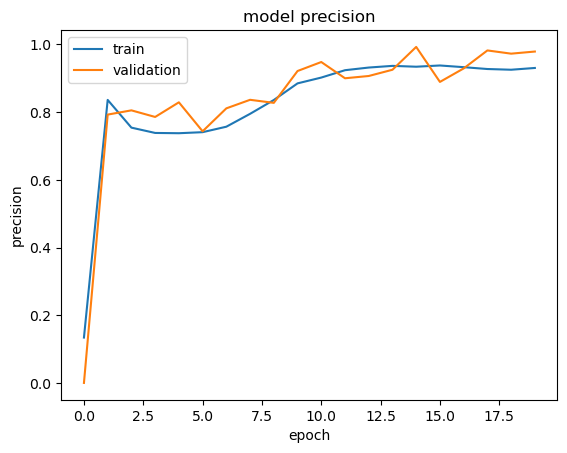

In [9]:
from matplotlib import pyplot as plt
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
from sklearn import metrics as mt
yhat = np.round(model1.predict([X_test_crossed,X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

305/305 [==============================] - 1s 2ms/step
[[8880    6]
 [ 567  279]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.98      0.33      0.49       846

    accuracy                           0.94      9732
   macro avg       0.96      0.66      0.73      9732
weighted avg       0.94      0.94      0.93      9732

Y hat
 [[   0 9447]
 [   1  285]]
actual
 [[   0 8886]
 [   1  846]]


#### 2.2 Investigate Performance by Altering the Number of Layers in the Deep Branch of the Network

Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two different number of layers. Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to select the number of layers that performs superiorly.

In [11]:
# we need to create separate lists for each branch
crossed_outputs = []

# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1


    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = df_train[col].max()+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
# 5 layer network
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=40,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=30,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model2 = Model(inputs=[input_crossed,input_cat,input_num],
              outputs=final_branch)

model2.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

history = model2.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
3893/3893 [==============================] - 16s 4ms/step - loss: 0.0912 - precision_1: 0.0571 - val_loss: 0.0769 - val_precision_1: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 14s 4ms/step - loss: 0.0758 - precision_1: 0.0000e+00 - val_loss: 0.0740 - val_precision_1: 0.0000e+00
Epoch 3/20
3893/3893 [==============================] - 15s 4ms/step - loss: 0.0739 - precision_1: 0.0000e+00 - val_loss: 0.0724 - val_precision_1: 0.0000e+00
Epoch 4/20
3893/3893 [==============================] - 16s 4ms/step - loss: 0.0727 - precision_1: 0.7722 - val_loss: 0.0713 - val_precision_1: 0.7865
Epoch 5/20
3893/3893 [==============================] - 17s 4ms/step - loss: 0.0718 - precision_1: 0.6880 - val_loss: 0.0708 - val_precision_1: 0.7826
Epoch 6/20
3893/3893 [==============================] - 17s 4ms/step - loss: 0.0713 - precision_1: 0.6898 - val_loss: 0.0705 - val_precision_1: 0.7634
Epoch 7/20
3893/3893 [==============================] - 15s 4ms/step - los

In [12]:
yhat = np.round(model2.predict([X_test_crossed,X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

305/305 [==============================] - 1s 2ms/step
[[8856   30]
 [ 550  296]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.91      0.35      0.51       846

    accuracy                           0.94      9732
   macro avg       0.92      0.67      0.74      9732
weighted avg       0.94      0.94      0.93      9732

Y hat
 [[   0 9406]
 [   1  326]]
actual
 [[   0 8886]
 [   1  846]]


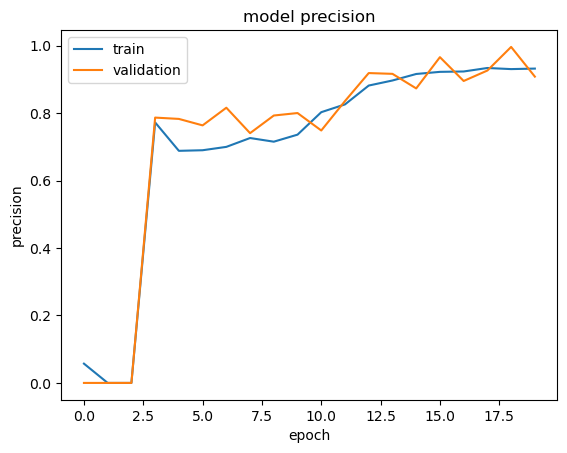

In [13]:
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 2.3 Third wide and deep network

In [14]:
# # get new crossed columns
# cross_columns = [
#     ['department','education'],
#     ['recruitment_channel','education'],
#     ['department', 'region'],
#     ['department', 'education', 'region']
# ]
# cross_col_df_names = []
# for cols_list in cross_columns:
#     # encode as ints for the embedding
#     enc = LabelEncoder()
#     # 1. create crossed labels by join operation
#     X_crossed_train = df_train[cols_list].apply(lambda x: '_'.join(x), axis=1)
#     X_crossed_test = df_test[cols_list].apply(lambda x: '_'.join(x), axis=1)
#
#     # get a nice name for this new crossed column
#     cross_col_name = '_'.join(cols_list)
#
#     # 2. encode as integers, stacking all possibilities
#     enc.fit(np.hstack((X_crossed_train.to_numpy(),  X_crossed_test.to_numpy())))
#
#     # 3. Save into dataframe with new name
#     df_train[cross_col_name] = enc.transform(X_crossed_train)
#     df_test[cross_col_name] = enc.transform(X_crossed_test)
#
#     # keep track of the new names of the crossed columns
#     cross_col_df_names.append(cross_col_name)
#
# cross_col_df_names

In [15]:
crossed_outputs = []
# CROSSED DATA INPUT
input_crossed = Input(shape=(X_train_crossed.shape[1],), dtype='int64', name='wide_inputs')
for idx,col in enumerate(cross_col_df_names):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1


    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_crossed, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = concatenate(crossed_outputs, name='wide_concat')

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
# 4 layer deep network
deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

# merge the deep and wide branch
final_branch = concatenate([wide_branch, deep_branch],
                           name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

model3 = Model(inputs=[input_crossed,input_cat,input_num],
              outputs=final_branch)

model3.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])

history = model3.fit([X_train_crossed,X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_crossed,X_test_cat,X_test_num],y_test))

Epoch 1/20
3893/3893 [==============================] - 14s 3ms/step - loss: 0.0909 - precision_2: 0.0000e+00 - val_loss: 0.0773 - val_precision_2: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0762 - precision_2: 0.0000e+00 - val_loss: 0.0747 - val_precision_2: 0.0000e+00
Epoch 3/20
3893/3893 [==============================] - 13s 3ms/step - loss: 0.0743 - precision_2: 0.0000e+00 - val_loss: 0.0733 - val_precision_2: 0.0000e+00
Epoch 4/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0733 - precision_2: 0.0000e+00 - val_loss: 0.0725 - val_precision_2: 0.0000e+00
Epoch 5/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0726 - precision_2: 0.0000e+00 - val_loss: 0.0720 - val_precision_2: 0.0000e+00
Epoch 6/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0720 - precision_2: 0.0000e+00 - val_loss: 0.0713 - val_precision_2: 0.0000e+00
Epoch 7/20
3893/3893 [========================

In [16]:
yhat = np.round(model3.predict([X_test_crossed,X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhat))
print(mt.classification_report(y_test,yhat))
unique_yhat, counts_yhat = np.unique(yhat, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

305/305 [==============================] - 1s 2ms/step
[[8863   23]
 [ 561  285]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.93      0.34      0.49       846

    accuracy                           0.94      9732
   macro avg       0.93      0.67      0.73      9732
weighted avg       0.94      0.94      0.93      9732

Y hat
 [[   0 9424]
 [   1  308]]
actual
 [[   0 8886]
 [   1  846]]


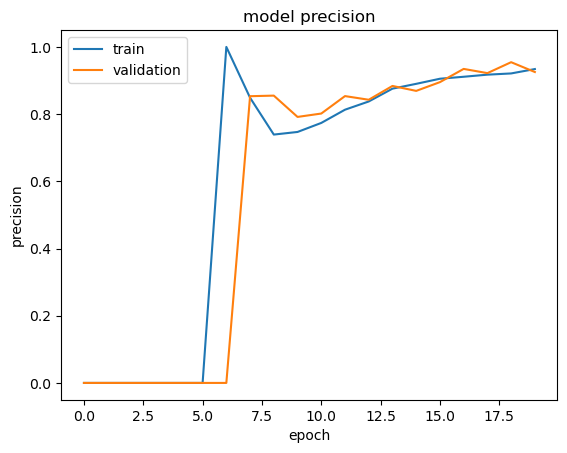

In [17]:
plt.plot(history.history['precision_2'])
plt.plot(history.history['val_precision_2'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### 2.4 Investigate Performance of the Best Wide and Deep Network to Multi-Layer Perceptron

Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models.  

In [18]:
# Now let's define the architecture for a multi-layer network

# reset this input branch
all_deep_branch_outputs = []

# CATEGORICAL DATA INPUT
input_cat = Input(shape=(X_train_cat.shape[1],), dtype='int64', name='categorical_input')
for idx,col in enumerate(categorical_headers_ints):

    # track what the maximum integer value will be for this variable
    # which is the same as the number of categories
    N = max(df_train[col].max(),df_test[col].max())+1

    # this line of code does this: input_branch[:,idx]
    x = tf.gather(input_cat, idx, axis=1)

    # now use an embedding to deal with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col+'_embed')(x)

    # save these outputs to concatenate later
    all_deep_branch_outputs.append(x)

# NUMERIC DATA INPUT
# create dense input branch for numeric
input_num = Input(shape=(X_train_num.shape[1],), name='numeric')
x_dense = Dense(units=22, activation='relu',name='num_1')(input_num)

all_deep_branch_outputs.append(x_dense)


# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
# 7 layers now

deep_branch = Dense(units=30,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

# merge the deep and wide branch
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(deep_branch)

MLPModel = Model(inputs=[input_cat,input_num],
              outputs=final_branch)
MLPModel.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.Precision()])
history = MLPModel.fit([X_train_cat,X_train_num],
                    y_train,
                    epochs=20,
                    batch_size=10,
                    verbose=1,
                    validation_data = ([X_test_cat,X_test_num],y_test))



Epoch 1/20
3893/3893 [==============================] - 14s 3ms/step - loss: 0.0937 - precision_3: 0.1170 - val_loss: 0.0787 - val_precision_3: 0.0000e+00
Epoch 2/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0773 - precision_3: 0.0000e+00 - val_loss: 0.0749 - val_precision_3: 0.0000e+00
Epoch 3/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0747 - precision_3: 0.0000e+00 - val_loss: 0.0733 - val_precision_3: 0.0000e+00
Epoch 4/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0736 - precision_3: 0.0000e+00 - val_loss: 0.0728 - val_precision_3: 0.0000e+00
Epoch 5/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0731 - precision_3: 0.0000e+00 - val_loss: 0.0724 - val_precision_3: 0.0000e+00
Epoch 6/20
3893/3893 [==============================] - 12s 3ms/step - loss: 0.0728 - precision_3: 0.0000e+00 - val_loss: 0.0722 - val_precision_3: 0.0000e+00
Epoch 7/20
3893/3893 [============================

In [19]:
yhatMLP = np.round(MLPModel.predict([X_test_cat,X_test_num])).astype(int)
print(mt.confusion_matrix(y_test,yhatMLP))
print(mt.classification_report(y_test,yhatMLP))
unique_yhat, counts_yhat = np.unique(yhatMLP, return_counts=True)
print("Y hat\n",np.asarray((unique_yhat, counts_yhat)).T)
unique_ytest, counts_ytest = np.unique(y_test, return_counts=True)
print("actual\n",np.asarray((unique_ytest, counts_ytest)).T)

305/305 [==============================] - 1s 2ms/step
[[8876   10]
 [ 575  271]]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      8886
           1       0.96      0.32      0.48       846

    accuracy                           0.94      9732
   macro avg       0.95      0.66      0.72      9732
weighted avg       0.94      0.94      0.93      9732

Y hat
 [[   0 9451]
 [   1  281]]
actual
 [[   0 8886]
 [   1  846]]


305/305 [==============================] - 2s 6ms/step


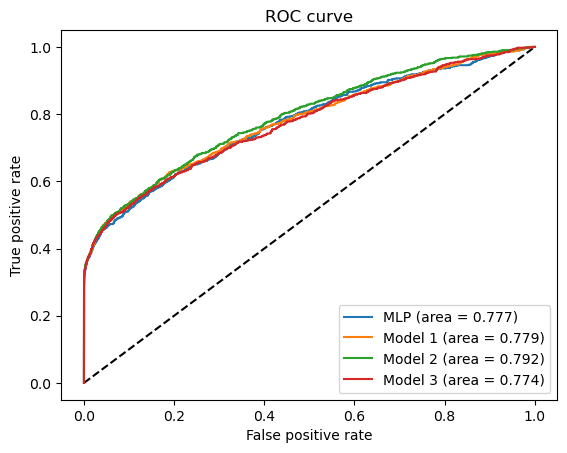

In [20]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
yhatMLP = MLPModel.predict([X_test_cat,X_test_num]).ravel()
fpr_mlp, tpr_mlp, thresholds_keras = roc_curve(y_test, yhatMLP)
auc_mlp = auc(fpr_mlp, tpr_mlp)
yhat_model1 = model1.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
fpr_model1, tpr_model1, thresholds_keras = roc_curve(y_test, yhat_model1)
auc_model1= auc(fpr_model1, tpr_model1)
yhat_model2 = model2.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
fpr_model2, tpr_model2, thresholds_keras = roc_curve(y_test, yhat_model2)
auc_model2= auc(fpr_model2, tpr_model2)
yhat_model3 = model3.predict([X_test_crossed,X_test_cat,X_test_num]).ravel()
fpr_model3, tpr_model3, thresholds_keras = roc_curve(y_test, yhat_model3)
auc_model3= auc(fpr_model3, tpr_model3)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp))
plt.plot(fpr_model1, tpr_model1, label='Model 1 (area = {:.3f})'.format(auc_model1))
plt.plot(fpr_model2, tpr_model2, label='Model 2 (area = {:.3f})'.format(auc_model2))
plt.plot(fpr_model3, tpr_model3, label='Model 3 (area = {:.3f})'.format(auc_model3))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

For each of the models we trained, we get a pretty similar ROC curve 

### 3. Capturing the Embedding Weights from the Deep Network

Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data.

In [21]:
model3.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 categorical_input (InputLayer)  [(None, 5)]         0           []                               
                                                                                                  
 tf.compat.v1.gather_19 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                                  
 tf.compat.v1.gather_20 (TFOpLa  (None,)             0           ['categorical_input[0][0]']      
 mbda)                                                                                            
                                                                                            

                                                                                                  
Total params: 7,381
Trainable params: 7,381
Non-trainable params: 0
__________________________________________________________________________________________________


In [36]:
dept_embeddings = model3.get_layer('department_int_embed').get_weights()[0]
print(encoders['department'].inverse_transform([0]))
print(len(dept_embeddings))
for i in range(len(dept_embeddings)):
    print(encoders['department'].inverse_transform([i]))
    print(dept_embeddings[i])
#words_embeddings = {w:embeddings[idx] for w, idx in word_to_index.items()}

['Analytics']
9
['Analytics']
[ 0.2902643  -0.41488695 -0.08212328]
['Finance']
[-0.20317261  0.21215482  0.0462893 ]
['HR']
[-0.0471026   0.0747899  -0.00090614]
['Legal']
[-0.027493    0.07885054 -0.00889239]
['Operations']
[-0.21041268  0.22136362 -0.04047974]
['Procurement']
[ 0.0486811  -0.06035383 -0.01558103]
['R&D']
[ 0.37671393 -0.43494526 -0.06906242]
['Sales & Marketing']
[-0.46922562  0.4938717   0.27329984]
['Technology']
[ 0.25130522 -0.23163876 -0.12537982]


['Analytics']
[ 0.2902643  -0.41488695 -0.08212328]
['Finance']
[-0.20317261  0.21215482  0.0462893 ]
['HR']
[-0.0471026   0.0747899  -0.00090614]
['Legal']
[-0.027493    0.07885054 -0.00889239]
['Operations']
[-0.21041268  0.22136362 -0.04047974]
['Procurement']
[ 0.0486811  -0.06035383 -0.01558103]
['R&D']
[ 0.37671393 -0.43494526 -0.06906242]
['Sales & Marketing']
[-0.46922562  0.4938717   0.27329984]
['Technology']
[ 0.25130522 -0.23163876 -0.12537982]


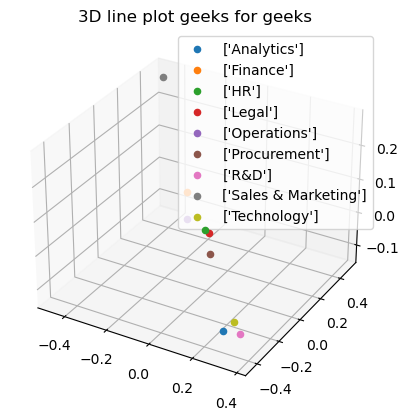

In [41]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure()
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
 
for i in range(len(dept_embeddings)):
    print(encoders['department'].inverse_transform([i]))
    print(dept_embeddings[i])
    ax.scatter(dept_embeddings[i][0],dept_embeddings[i][1],dept_embeddings[i][2], 'green', label = encoders['department'].inverse_transform([i]) )
# plotting
#ax.plot3D(x, y, z, 'green')
ax.set_title('3D line plot geeks for geeks')
plt.legend(loc='best')
plt.show()